In [1]:
import numpy as np

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load the input data

In [60]:
system="Cr14"
data=np.loadtxt("GSFE_VASP_DATA/"+system+".txt")
data2=np.loadtxt("GSFE_VASP_DATA/"+system+"_inp.txt")

In [61]:
alat=data2[0]    #Lattice parameter
mu=data2[1]/160.2176621  #Shear modulus
nu=data2[2]         #Poisson's ratio

In [62]:
h=np.sqrt(3)*alat*np.sqrt(2)/2  #periodicity of gamma surface along z
b=alat*np.sqrt(2)/2           #periodicity of gamma surface along x

In [63]:
data=np.array([data.T[0]*b,data.T[1]*h,data.T[2]]).T

In [64]:
l=alat/np.sqrt(2)*np.sqrt(2/3)     #separation between the two linear elastic half-spaces in the Peierls-Nabarro model
w=l/2/(1-nu)  #width of the dislocation

### Fit $\gamma$ surface

In [65]:
def gamma(xz,R1,R2,R3,I1,I2):
    x,z=xz
    x=x*2*np.pi/b
    z=z*2*np.pi/np.sqrt(3)/b
    res=0
    res+=R1*(cos(x-z)+cos(x+z)+cos(2*z))
    res+=R2*(cos(x-z)+cos(x+z)+cos(2*x))
    res+=R3*(cos(2*x+2*z)+cos(2*x-2*z)+cos(4*z))
    res+=I1*(sin(x-z)-sin(x+z)+sin(2*z))
    res+=I2*(sin(2*x-2*z)-sin(2*x+2*z)+sin(4*z))
    res-=3*(R1+R2+R3)
    return res

In [66]:
from scipy.optimize import curve_fit

In [67]:
popt,pcov=curve_fit(gamma,data.T[:2],data.T[2])#,sigma=sigma)

In [68]:
from mpl_toolkits.mplot3d import axes3d

In [69]:
Nx=50
Ny=50
xx=np.linspace(0,b,Nx)
yy=np.linspace(0,h,Ny)
X=np.array(list(xx)*Ny).reshape(Ny,Nx).T
Y=np.array(list(yy)*Nx).reshape(Nx,Ny)
Z=[]
for xi in xx:
    for yi in yy:
        Z.append(gamma((xi,yi),*popt))
Z=np.array(Z).reshape(Nx,Ny)

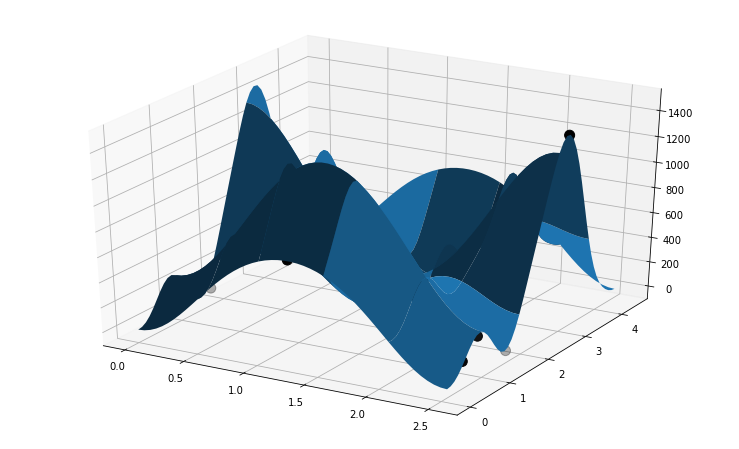

In [70]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=10, cstride=10)
ax.scatter(data.T[0][:4]+b,data.T[1][:4],data.T[2][:4],c="black",s=100)
ax.scatter(data.T[0][4:],data.T[1][4:],data.T[2][4:],c="black",s=100)
plt.show()

In [71]:
print("ISF:",gamma((0,h/3),*popt))
print("USF:",gamma((0,h/6),*popt))
print("MAX:",gamma((0,2*h/3),*popt))
print("USF110:",gamma((b/2,0),*popt))
xmesh=np.arange(0,h,0.05)
mus=(gamma((0,xmesh[1:]),*popt)-gamma((0,xmesh[:-1]),*popt))/0.05/100*2*np.pi
xmesh=np.arange(0,b,0.05)
mus2=(gamma((xmesh[1:],0),*popt)-gamma((xmesh[:-1],0),*popt))/0.05/100*2*np.pi
print("mu <211>= %3.0f GPa" % (max(mus)))
print("mu <110>= %3.0f GPa" % (max(mus2)))

ISF: 32.18754776003141
USF: 293.3959879265641
MAX: 1459.5247628221132
USF110: 769.2417045559257
mu <211>=  81 GPa
mu <110>=  63 GPa


### Find equilibrium $d$

In [72]:
import sympy as sym

In [73]:
M=1000   #a big number, has to be converged
r=M*b
be1=1/2*b   #edge component of first partial in Angstrom
be2=1/2*b   #edge component of second partial in Angstrom
bs1=-np.sqrt(3)/6*b   #screw component of first partial in Angstrom
bs2=np.sqrt(3)/6*b   #screw component of second partial in Angstrom
[R1,R2,R3,I1,I2]=popt
d = sym.Symbol('d')
ics = sym.Symbol('x')

Calculating $\frac{\partial E_\text{elastic}}{\partial d} = -\frac{H_{11}}{8} \frac{b^2 d}{w_1^2 + \frac{d^2}{4}} - \frac{H_{33}}{2} \frac{b_{s1}^2 d}{w_2^2 + \frac{d^2}{4}}$

In [74]:
ux=(be1*sym.atan((ics+d)/w)+be2*sym.atan((ics-d)/w))/sym.pi+be1/2+be2/2 #disregistry x
uz=(bs1*sym.atan((ics+d)/w)+bs2*sym.atan((ics-d)/w))/sym.pi+bs1/2+bs2/2 #disregistry z

In [75]:
H11=mu/4/np.pi*(1-nu)
H33=mu/4/np.pi
def dElastic_energy(dee):    #Zongrui
    res=0
    res-=H11*b**2/8*dee/w**2/(1+dee**2/4/w**2)
    res-=H33*bs1**2/2*dee/w**2/(1+dee**2/4/w**2)
    return res

Calculating $\frac{\partial E_\text{misfit}}{\partial d} = \int_{-r}^{r} \frac{\partial \gamma[u_x(x,d),u_z(x,d)]}{\partial d} dx$

In [76]:
uux=ux*2*sym.pi/b
uuz=uz*2*sym.pi/h
gamma_symb=R1*(sym.cos(uux-uuz)+sym.cos(uux+uuz)+sym.cos(2*uuz))+R2*(sym.cos(uux-uuz)+sym.cos(uux+uuz)+sym.cos(2*uux))+R3*(sym.cos(2*uux+2*uuz)+sym.cos(2*uux-2*uuz)+sym.cos(4*uuz))+I1*(sym.sin(uux-uuz)-sym.sin(uux+uuz)+sym.sin(2*uuz))+I2*(sym.sin(2*uux-2*uuz)-sym.sin(2*uux+2*uuz)+sym.sin(4*uuz))-3*(R1+R2+R3)

In [77]:
dgamma=sym.lambdify((d,ics),sym.diff(gamma_symb, d))

In [78]:
def dMisfit_energy(dee):
    xs=np.linspace(-r,r+1,M*20)
    y=[]
    for ex in xs:
        y.append(dgamma(dee,ex)*6.241506479963200E-5) #mJ/m^2 to eV/A^2
        #print(dgamma(dee,ex))
    y=np.array(y)
    res=[]
    for ys in y.T:
        res.append(np.trapz(ys,x=xs))
    return np.array(res)

Calculating $E_\text{misfit} = \int_{-r}^{r} \gamma[u_x(x,d),u_z(x,d)] dx$

In [79]:
gamma_f=sym.lambdify((d,ics),gamma_symb)

Minimization: $\frac{\partial E_\text{elastic}}{\partial d} + \frac{\partial E_\text{misfit}}{\partial d} = 0$

In [80]:
def dE_tot(dd):
    return dElastic_energy(dd)+dMisfit_energy(dd)

In [81]:
from scipy.optimize import fsolve

In [82]:
initial_guess=12
dstar=fsolve(dE_tot, initial_guess)[0]

In [85]:
print("d = %3.1f nm" % (dstar*2/10))

d = 6.4 nm


In [86]:
print("ISF eff = %3.1f mJ/m2" % (dMisfit_energy(np.array([dstar]))[0]/6.241506479963200E-5/2))

ISF eff = 33.8 mJ/m2


### Peierls-Nabarro stress

In [87]:
ap=b
def E_misfit_1d(u,s):
    dstar1=np.around(2*dstar/ap)*ap/2
    dstar2=np.around(2*dstar/ap)*ap/2+s
    y=0
    for m in range(-M,M+1):
        x=(m)*ap-u
        ux=(be1*np.arctan((x+dstar1)/w)+be2*np.arctan((x-dstar2)/w))/np.pi+be1/2+be2/2 #disregistry x
        uz=(bs1*np.arctan((x+dstar1)/w)+bs2*np.arctan((x-dstar2)/w))/np.pi+bs1/2+bs2/2 #disregistry z
        y+=gamma((ux,uz),*popt)*6.241506479963200E-5*ap
    return y


In [88]:
def PNstress(s):
    dx=0.05
    xmesh=np.arange(-ap/2,ap/2,dx)
    return max((E_misfit_1d(xmesh[1:],s)-E_misfit_1d(xmesh[:-1],s))/dx/ap)/ap

In [89]:
from scipy.optimize import minimize

In [90]:
minim=minimize(PNstress,ap/2,tol=0.0005)
print("PN stress= %3.0f MPa" % (minim["fun"]*160217.6621))

PN stress=  59 MPa
